# 1. KBO 타자 OPS 예측

## 1.1 문제 정의
### 1.1.1 경진대회 소개

![경진대회소개 이미지](img/1.png)
![경진대회 개요](img/2.png)

![경진대회 배경](img/3.png)

### 1.1.2 평가척도

WRMSE(Weighted Root Mean Squeare Error)
![경진대회 배경](img/4.png)
실제값과 예측값의 차이를 기준으로 평가하므로 오차가 적을수록 좋음.

타석에 들어서지 못한 선수들은 가중치가 0이므로 계산 결과도 0이됨.

![WRMSE 평가 예시](img/5.png)

### 1.1.3 도메인 조사
![분석에 필요한 주요 야구 용어](img/6.png)

## 1.2. 탐색적 데이터 분석

In [202]:
# 필요 라이브러리 로드
from matplotlib import font_manager, rc
import matplotlib
import  matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import  seaborn as sns
import  platform

%matplotlib inline
# 윈도우인 경우 맑은 고딕 폰트 이용
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
# Mac 인 경우
else :
    rc('font', family='AppleGothic', size=8)


#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
matplotlib.rcParams['axes.unicode_minus'] = False

### 1.2.1. 프리시즌 데이터 분석

In [203]:
# 프리시즌 데이터 로드
preseason_df = pd.read_csv('data\Pre_Season_Batter.csv')


# 정규시즌 데이터 로드
regular_season_df = pd.read_csv('data\Regular_Season_Batter.csv')

# 데이터 크기 확인
preseason_df.shape
# 데이터 상단 출력

preseason_df.head()



,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,...,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493


In [61]:
preseason_df.info()
# SLG  + OBP  =  OPS 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393 entries, 0 to 1392
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   batter_id        1393 non-null   int64  
 1   batter_name      1393 non-null   object 
 2   year             1393 non-null   int64  
 3   team             1393 non-null   object 
 4   avg              1393 non-null   object 
 5   G                1393 non-null   int64  
 6   AB               1393 non-null   int64  
 7   R                1393 non-null   int64  
 8   H                1393 non-null   int64  
 9   2B               1393 non-null   int64  
 10  3B               1393 non-null   int64  
 11  HR               1393 non-null   int64  
 12  TB               1393 non-null   int64  
 13  RBI              1393 non-null   int64  
 14  SB               1393 non-null   int64  
 15  CS               1393 non-null   int64  
 16  BB               1393 non-null   int64  
 17  HBP           

In [197]:
# 데이터 기초통계량 확인
preseason_df.describe()
#min 200년 부터 max  2018 년까지 데이터가 있는것

,batter_id,year,G,AB,R,H,2B,3B,HR,TB,...,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,...,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1364.000000,1368.000000,1393.000000,1364.000000
mean,173.434314,2013.014358,8.705671,19.201723,2.679828,5.021536,0.954774,0.119885,0.391960,7.391960,...,0.629576,0.291457,1.877961,0.330223,3.714286,0.447236,0.361012,0.317912,0.381910,0.676924
std,94.716851,4.166757,5.562686,13.395946,2.637212,4.232584,1.196904,0.379976,0.748557,6.538787,...,1.146854,0.595522,2.053392,0.642204,3.180884,0.723364,0.269892,0.151489,0.729521,0.386933
min,0.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.000000,2010.000000,6.000000,9.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.217000,0.250000,0.000000,0.472000
50%,178.000000,2014.000000,9.000000,18.000000,2.000000,4.000000,1.000000,0.000000,0.000000,6.000000,...,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.344500,0.333000,0.000000,0.675000
75%,254.000000,2017.000000,11.000000,28.000000,4.000000,8.000000,2.000000,0.000000,1.000000,11.000000,...,1.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.478000,0.400000,1.000000,0.867000
max,344.000000,2018.000000,119.000000,183.000000,35.000000,51.000000,11.000000,4.000000,5.000000,68.000000,...,9.000000,4.000000,21.000000,4.000000,36.000000,5.000000,4.000000,1.000000,5.000000,5.000000


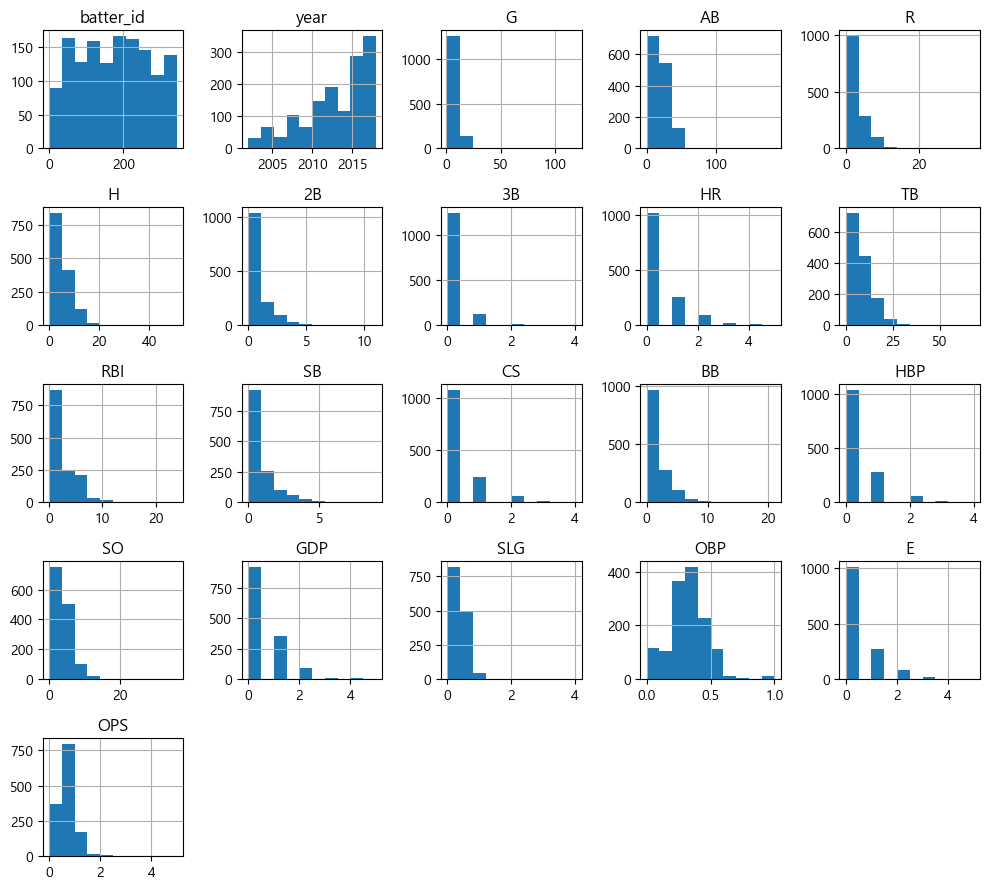

In [205]:
# 데이터 시각화
preseason_df.hist(figsize=(10,9))
plt.tight_layout()
plt.show()

In [206]:
# 정규시즌 데이터에서 2002년 이후의 연도별 기록된 선수의 수 ##name--> rename('regular')바꿀수있음
regular_count = regular_season_df.groupby('year').count()['batter_id'] .rename('regular')
regular_count

year
1993      1
1994      2
1995      1
1996      7
1997      8
1998     10
1999     14
2000     20
2001     32
2002     43
2003     54
2004     68
2005     73
2006     85
2007     98
2008    115
2009    124
2010    130
2011    151
2012    174
2013    194
2014    186
2015    207
2016    213
2017    217
2018    227
Name: regular, dtype: int64

In [207]:
# 프리시즌 데이터에서 연도별 기록된 선수의 수
preseason_count = preseason_df.groupby('year').count()['batter_id'].rename('preseason')
preseason_count 

year
2002     12
2003     19
2004     28
2005     37
2006     36
2007     43
2008     61
2009     66
2010     72
2011     75
2012     87
2013    104
2014    117
2015    134
2016    153
2017    167
2018    182
Name: preseason, dtype: int64

In [250]:
pd.concat([regular_count,
           preseason_count,
           np.round(regular_count/preseason_count,2).rename('ratio')],axis=1).T.loc[:,2002:]
           
           

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
regular,43.00,54.00,68.00,73.00,85.00,98.00,115.00,124.00,130.00,151.00,174.0,194.00,186.00,207.00,213.00,217.0,227.00
preseason,12.00,19.00,28.00,37.00,36.00,43.00,61.00,66.00,72.00,75.00,87.0,104.00,117.00,134.00,153.00,167.0,182.00
ratio,3.58,2.84,2.43,1.97,2.36,2.28,1.89,1.88,1.81,2.01,2.0,1.87,1.59,1.54,1.39,1.3,1.25


In [87]:
#프리시즌 성적과 정규시즌의 성적 간의 상관관계를 살펴보기 위해 두 데이터에 공통적으로 존제하는 선수들의 기록만 정리

# 타자의 이름과 연도를 이용해 새로운 인덱스를 생성
regular_season_df['new_idx'] = regular_season_df['batter_name'] + regular_season_df['year'].apply(str)
preseason_df['new_idx'] = preseason_df['batter_name'] + preseason_df['year'].apply(str)

In [90]:
# 새로운 인덱스의 교집합
intersection_idx = list(set(regular_season_df['new_idx']).intersection(preseason_df['new_idx']))
len(intersection_idx)

1358

In [94]:
# 교집합에 존재하는 데이터만 불러오기
regular_season_new = regular_season_df.loc[regular_season_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()

regular_season_new  = regular_season_new.sort_values(by='new_idx').reset_index(drop=True)
regular_season_new .head(2)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,가르시아2018
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2011


In [97]:
# 비교를 위해 인덱스로 정렬  (preseason 데이터도 동일하게)
preseason_df_new = preseason_df.loc[preseason_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()
preseason_df_new = preseason_df_new.sort_values(by='new_idx').reset_index(drop=True)
preseason_df_new.head(2)



,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,0.55,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959,가르시아2018
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0.00,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500,강경학2011


In [98]:
# 검정 코드
print(regular_season_new.shape,preseason_df_new.shape)
sum(regular_season_new['new_idx']==preseason_df_new['new_idx'])

(1358, 30) (1358, 30)


1358

In [194]:
import matplotlib

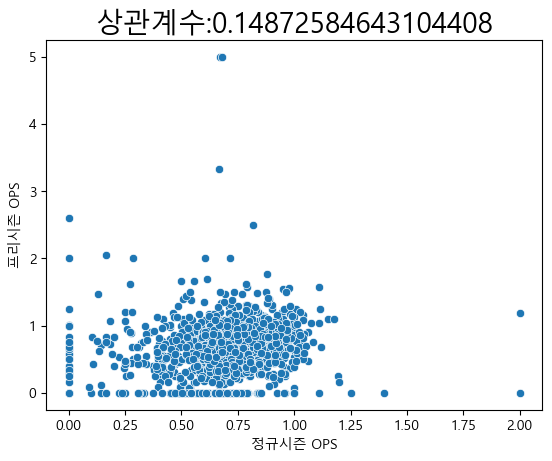

In [195]:
# 정규시즌과 프리시즌의 상관관계 계산
correlation= regular_season_new['OPS'].corr(preseason_df_new['OPS'])
sns.scatterplot(x=regular_season_new['OPS'], y=preseason_df_new['OPS'])
plt.title('상관계수:'+str(correlation),fontsize=20)
plt.xlabel('정규시즌 OPS')
plt.ylabel('프리시즌 OPS')

plt.show()

### 1.2.2. 정규시즌 데이터 분석

In [106]:
regular_season_df.shape

(2454, 30)

In [107]:
regular_season_df.head(2)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,가르시아2018
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2011


In [108]:
regular_season_df.describe()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,...,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2428.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,...,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2428.000000,2430.000000,2454.000000,2428.000000
mean,178.079462,2011.614507,0.237559,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,...,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.343826,0.306684,3.676447,0.649939
std,97.557947,4.992833,0.098440,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,...,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.163335,0.111778,4.585248,0.261634
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.203000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.267454,0.272727,0.000000,0.546000
50%,183.000000,2013.000000,0.255000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,...,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.360124,0.328592,2.000000,0.688637
75%,265.000000,2016.000000,0.291000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,...,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.436000,0.367000,5.000000,0.797234
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,...,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


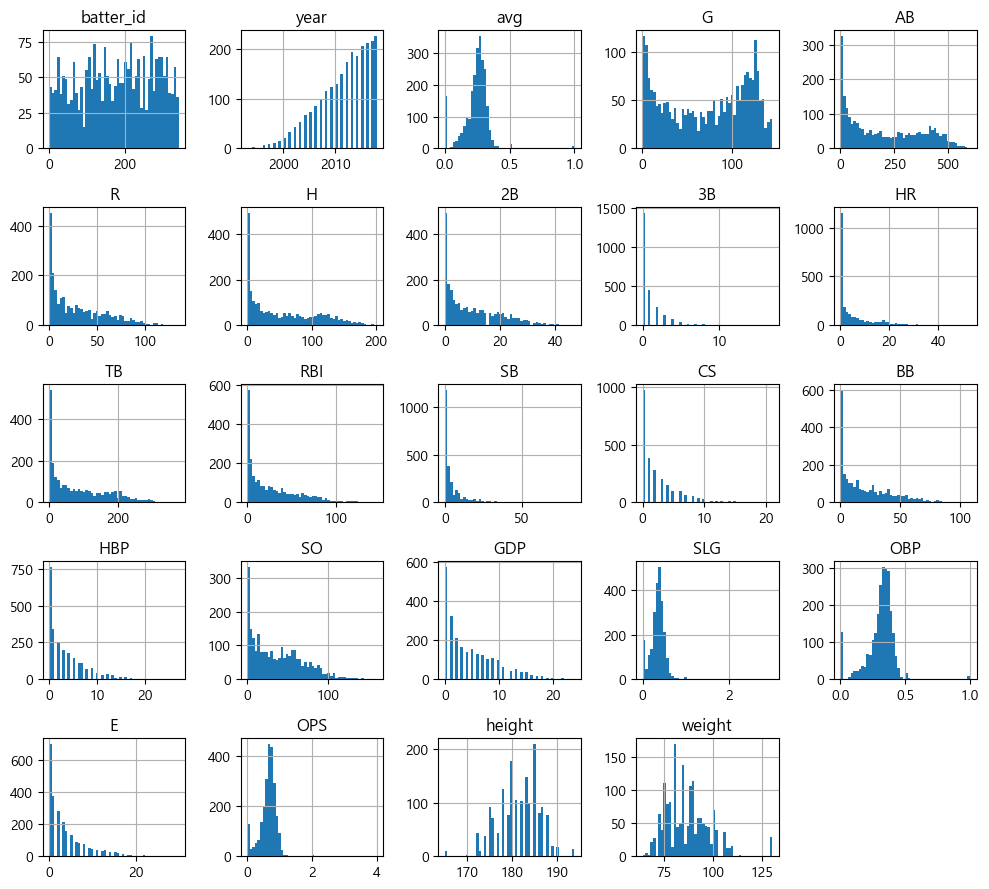

In [171]:
regular_season_df.hist(bins=50,figsize=(10,9))
plt.tight_layout()
plt.show()

<a id='m1'>연도별 OPS 중앙값 그래프</a>

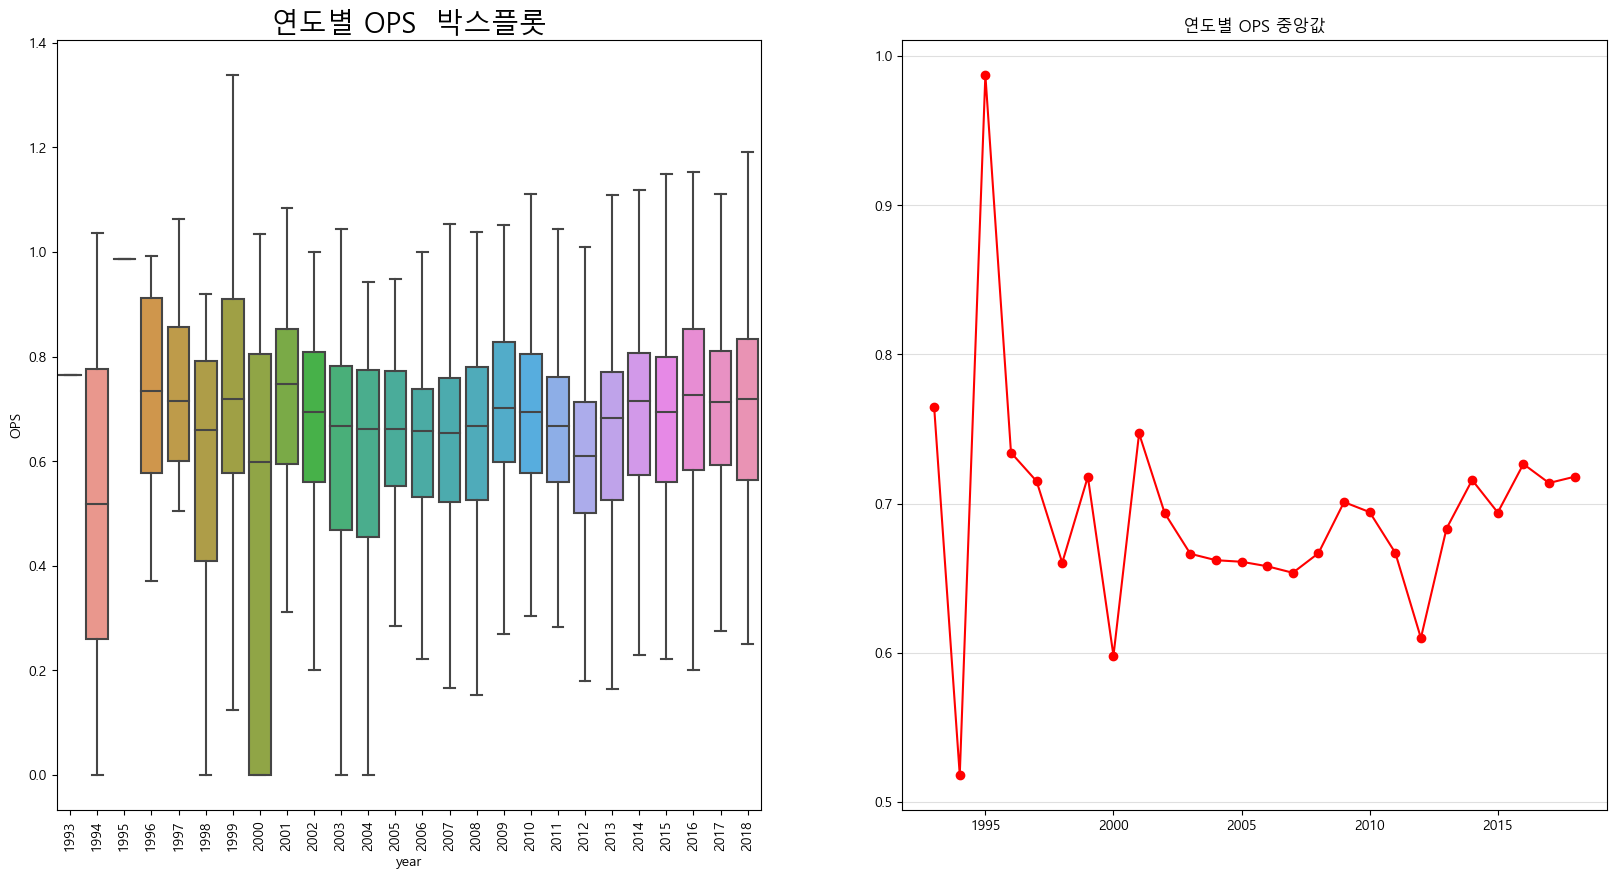

In [169]:
plt.figure(figsize=(20,10))
# 1행 2열 1번쨰
plt.subplot(1,2,1)
g = sns.boxplot(data=regular_season_df,x='year',y='OPS',showfliers =False)
# 연도별 함수
g.set_title("연도별 OPS  박스플롯", size =20)
# 아래 연도 를 90도로 정리 해주는 함수
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.subplot(1,2,2)
# plt.plot(regular_season_df['year'],regular_season_df['OPS'],'ro')
plt.plot(regular_season_df.groupby('year')['OPS'].median(),marker='o',color='red')
plt.grid(axis='y',linestyle='-',alpha=0.4)
plt.title('연도별 OPS 중앙값')
plt.show()


In [125]:
pd.crosstab(regular_season_df['year'],'count').T            #도수 분포표

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
col_0,,,,,,,,,,,,,,,,,,,,,
count,1,2,1,7,8,10,14,20,32,43,...,124,130,151,174,194,186,207,213,217,227


<a id='m2'>연도별 팀 OPS</a>

In [187]:
# 연도별 팀의 OPS 중앙값 계산
med_OPS_team = regular_season_df.pivot_table(index='team', columns='year', values='OPS', aggfunc='median')


med_OPS_team 

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
team,,,,,,,,,,,,,,,,,,,,,
KIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.849337,0.829906,...,0.707000,0.725000,0.680963,0.615420,0.679763,0.751196,0.598500,0.777000,0.777000,0.7320
KT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.643561,0.634500,0.710791,0.6550
LG,NaN,0.000000,NaN,0.476212,0.679836,0.509843,0.637173,0.689250,0.698978,0.645345,...,0.704000,0.677000,0.626000,0.552501,0.653000,0.680809,0.678000,0.729000,0.703000,0.7040
NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.652500,0.636742,0.711000,0.703000,0.705000,0.6000
OB,NaN,NaN,NaN,NaN,0.615797,0.727667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.596491,0.393000,...,0.822977,0.689176,0.710000,0.666953,0.689636,0.751500,0.714000,0.798500,0.764796,0.7685
넥센,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.636166,0.623000,0.589000,0.671000,0.792032,0.753000,0.800500,0.743500,0.7650
두산,NaN,NaN,NaN,NaN,NaN,NaN,0.853830,0.739755,0.695808,0.762809,...,0.701938,0.780000,0.733000,0.660000,0.781500,0.702330,0.760000,0.763000,0.685000,0.8230
롯데,NaN,NaN,NaN,NaN,NaN,NaN,1.124961,0.453390,0.577847,0.577000,...,0.680000,0.653000,0.676715,0.581845,0.600000,0.689000,0.622000,0.704000,0.728000,0.7100


In [188]:
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
med_OPS_team .loc[:,2005:].isna().sum(axis=1) 

team
KIA      0
KT      10
LG       0
NC       8
OB      14
SK       0
넥센       5
두산       0
롯데       0
삼성       0
쌍방울     14
우리      13
한화       0
해태      14
현대      11
히어로즈    13
dtype: int64

In [189]:
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
team_idex = med_OPS_team .loc[:,2005:].isna().sum(axis=1) <=0

team_idex 

team
KIA      True
KT      False
LG       True
NC      False
OB      False
SK       True
넥센      False
두산       True
롯데       True
삼성       True
쌍방울     False
우리      False
한화       True
해태      False
현대      False
히어로즈    False
dtype: bool

In [190]:
data  = med_OPS_team .loc[team_idex,2005:].T
data

team,KIA,LG,SK,두산,롯데,삼성,한화
year,,,,,,,
2005,0.583333,0.657000,0.601000,0.699575,0.673000,0.741419,0.577151
2006,0.717176,0.593128,0.682591,0.639750,0.586748,0.734067,0.624351
2007,0.546944,0.661500,0.774000,0.656000,0.629000,0.602000,0.665602
2008,0.644474,0.622015,0.693000,0.702000,0.725455,0.681104,0.562049
2009,0.707000,0.704000,0.822977,0.701938,0.680000,0.694336,0.672000
2010,0.725000,0.677000,0.689176,0.780000,0.653000,0.771000,0.628597
2011,0.680963,0.626000,0.710000,0.733000,0.676715,0.677606,0.649190
2012,0.615420,0.552501,0.666953,0.660000,0.581845,0.614071,0.583929
2013,0.679763,0.653000,0.689636,0.781500,0.600000,0.721250,0.616000


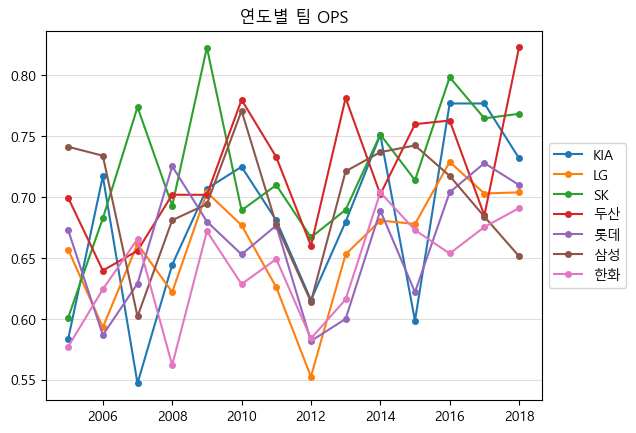

In [193]:
plt.plot(data,marker='o',markersize=4)
plt.grid(axis='y',linestyle='-',alpha=0.4)
plt.legend(data.columns,loc='center left',bbox_to_anchor=(1,0.5))    # 각 선들이 어떤 팀인지 알려줌.->범례확인
plt.title('연도별 팀 OPS')
plt.show()


In [166]:
import pandas as pd
import re
# dtype: object ---> int 바꿔줘야함  int로 감싸줘야함
# 키
regular_season_df['height'] = regular_season_df['height/weight'].apply(lambda x: int(re.findall('\d+',x.split('/')[0])[0]) if pd.notnull(x) else x)
# 몸무게
regular_season_df['weight'] = regular_season_df['height/weight'].apply(lambda x: int(re.findall('\d+',x.split('/')[1])[0]) if pd.notnull(x) else x)


print(regular_season_df['height/weight'][0],
      regular_season_df['height'][0],
      regular_season_df['weight'][0])

177cm/93kg 177.0 93.0


<function matplotlib.pyplot.show(close=None, block=None)>

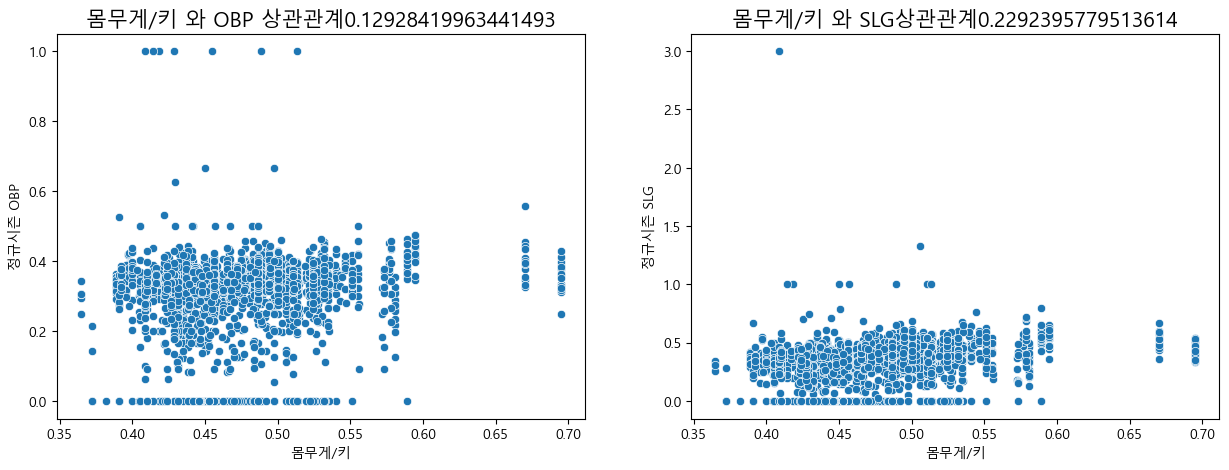

In [186]:
# 몸무게/키 계산
regular_season_df['weight_per_height']= regular_season_df['weight']/regular_season_df['height']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['OBP'])
sns.scatterplot(x=regular_season_df['weight_per_height'] , y=regular_season_df['OBP'] )
plt.title('몸무게/키 와 OBP 상관관계'+str(correlation),fontsize=15)
plt.ylabel('정규시즌 OBP')
plt.xlabel('몸무게/키')

# 정규시즌과 프리시즌의 상관관계 계산
plt.subplot(1,2,2)

correlation = regular_season_df['weight_per_height'].corr(regular_season_df['SLG'])
sns.scatterplot(x=regular_season_df['weight_per_height'] , y=regular_season_df['SLG'] )
plt.title('몸무게/키 와 SLG상관관계'+str(correlation),fontsize=15)
plt.ylabel('정규시즌 SLG')
plt.xlabel('몸무게/키')
plt.show


In [217]:
regular_season_df['position'].value_counts()

position
내야수(우투우타)    643
외야수(우투우타)    230
외야수(좌투좌타)    201
포수(우투우타)     189
외야수(우투좌타)    184
내야수(우투좌타)    141
내야수(좌투좌타)     36
포수(우투좌타)      14
외야수(우투양타)      7
내야수(우투양타)      7
Name: count, dtype: int64

In [216]:
# position
regular_season_df['pos'] = regular_season_df['position'].apply(lambda x: x.split('(')[0] if pd.notnull(x) else x)

# 우타, 좌타, 양타
regular_season_df['hit_way'] = regular_season_df['position'].apply(lambda x: x[-3:-1] if pd.notnull(x) else x)

print(regular_season_df['position'][0],
        regular_season_df['pos'][0],
        regular_season_df['hit_way'][0])

내야수(우투우타) 내야수 우타


# # 2번 그래프   'pos' 와 'hit_way' 비교

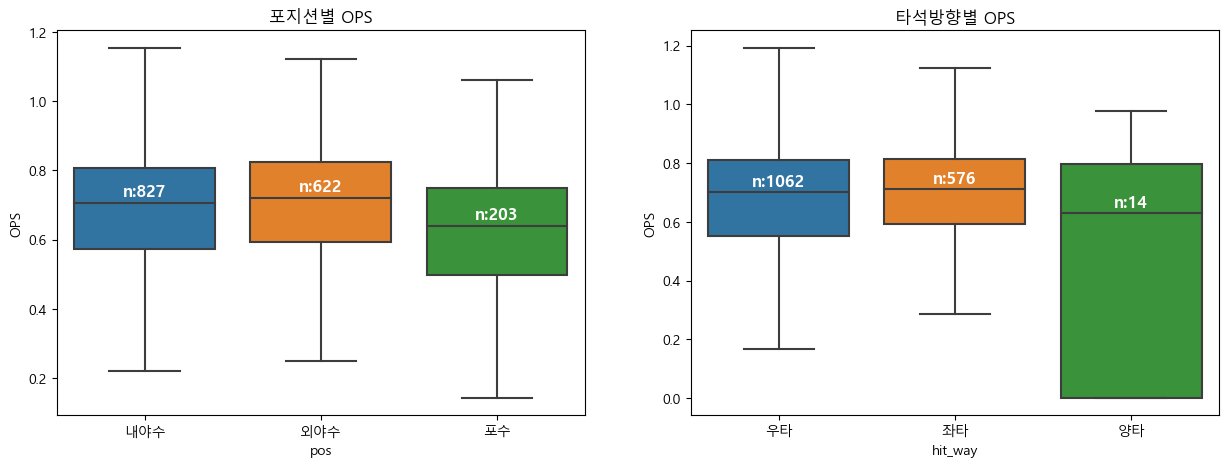

In [232]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.boxplot(data=regular_season_df, x='pos', y='OPS', showfliers=False)
medians = regular_season_df.groupby(['pos'])['OPS'].median().to_dict()
nobs = regular_season_df['pos'].value_counts().to_dict()

for key in nobs:
    nobs[key] ="n:"+str(nobs[key])
    
# nobs
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]
# xticks_labels
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()),
            # medians  값이  딕셔너리 임
            medians[label.get_text()]+0.02,
            
            nobs[label.get_text()],
            # 중앙 정렬
            horizontalalignment='center', size ='large', color='w', weight='semibold'
            )
    
ax.set_title('포지션별 OPS')

#####################################################################
# 2번 그래프   'pos' 와 'hit_way' 비교

plt.subplot(1,2,2)
ax =sns.boxplot(data=regular_season_df, x='hit_way', y='OPS', showfliers=False)
medians = regular_season_df.groupby(['hit_way'])['OPS'].median().to_dict()
nobs = regular_season_df['hit_way'].value_counts().to_dict()

for key in nobs:
    nobs[key] ="n:"+str(nobs[key])
    
# nobs
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]
# xticks_labels
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()),
            # medians  값이  딕셔너리 임
            medians[label.get_text()]+0.02,
            
            nobs[label.get_text()],
            # 중앙 정렬
            horizontalalignment='center', size ='large', color='w', weight='semibold'
            )
ax.set_title('타석방향별 OPS')
plt.show()

In [233]:
regular_season_df['career'].head()

0    쿠바 Ciego de Avila Maximo Gomez Baez(대)
1                         광주대성초-광주동성중-광주동성고
2                         광주대성초-광주동성중-광주동성고
3                         광주대성초-광주동성중-광주동성고
4                         광주대성초-광주동성중-광주동성고
Name: career, dtype: object

In [241]:
# career를 split
import numpy as np
from sympy.abc import x
foreign_country = regular_season_df['career'].apply(lambda x: x.replace('-',' ').split()[0])
# 외국만 추출
foreign_country_list = list(set(foreign_country.apply(lambda x : np.nan if '초' in x else x)))
# 결측치 처리
[x  for x in foreign_country_list if str(x) != 'nan']

['미국', '캐나다', '네덜란드', '쿠바', '도미니카']

In [244]:
regular_season_df['country']= foreign_country
regular_season_df['country'] = regular_season_df['country'].apply(lambda x: x if pd.isnull(x) else ('foreign' if x in foreign_country_list else 'korean'))

regular_season_df['country'].head(2)

0    foreign
1     korean
Name: country, dtype: object

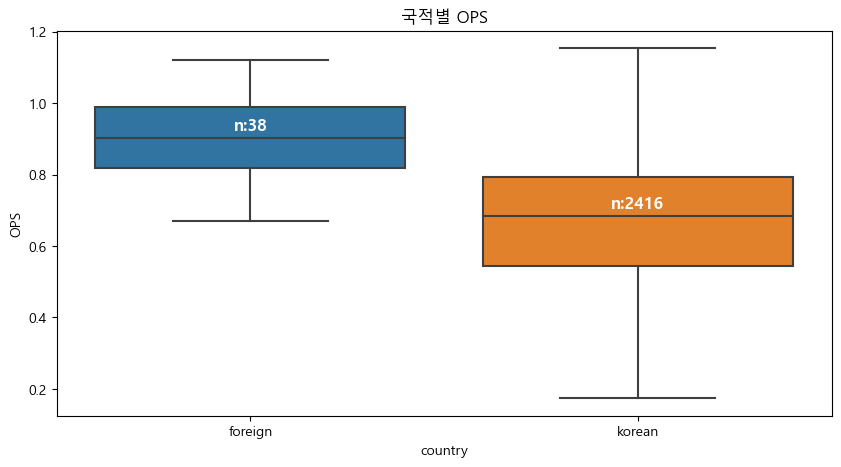

In [248]:
# 국적별로
plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
ax = sns.boxplot(data=regular_season_df, x='country', y='OPS', showfliers=False)
medians = regular_season_df.groupby(['country'])['OPS'].median().to_dict()
nobs = regular_season_df['country'].value_counts().to_dict()

for key in nobs:
    nobs[key] ="n:"+str(nobs[key])
    
# nobs
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]
# xticks_labels
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()),
            # medians  값이  딕셔너리 임
            medians[label.get_text()]+0.02,
            
            nobs[label.get_text()],
            # 중앙 정렬
            horizontalalignment='center', size ='large', color='w', weight='semibold'
            )
    
ax.set_title('국적별 OPS') 
plt.show()

In [18]:
# 결측치라면 그대로 0으로 두고 ‘만원’이 포함되어 있다면 숫자만 뽑아서 초봉으로 넣어준다. 그외 만 원 단위가 아닌 초봉은 결측치로 처리한다.


### 1.2.3. 일별 데이터 분석

In [19]:
# 날짜(date)를 ‘.’을 기준으로 나누고 첫 번째 값을 월(month)로 지정 


# 각 연도의 월별 평균 누적 타율(avg2) 계산


# pivot_table을 이용해 데이터 변형


<a id='m3'>연도별 월 평균 타율</a>

## 1.3. 데이터 전처리

In [20]:
# 수치형 타입의 변수 저장


# 수치형 타입 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출


In [21]:
# 수치형 변수에 포함되는 데이터 타입 선정


# 정규 시즌 데이터에서 결측치를 0으로 채우기


In [22]:
# 일별 데이터에서 결측치를 0으로 채우기


In [23]:
# 프리시즌 데이터에서 결측치를 0으로 채우기


In [24]:
# 수치형이 아닌 변수 추출


# 수치형이 아닌 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출


In [25]:
# 삭제할 데이터 추출
        

# 데이터 삭제


### 1.3.2. 규정 타수 정의

In [26]:
# OPS 이상치 탐색을 위한 수치 정의


# 실제 OPS 이상치 탐색


<a id='m4'>7월 일별 경기수 합</a>

In [27]:
# 7.01~7.31 숫자 생성 후 반 올림


### 1.3.3. 시간 변수

In [28]:
# 시간 변수를 생성하는 함수 정의


In [29]:
# 상관관계를 탐색할 변수 선택


In [30]:
# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출


In [31]:
# 상관관계 도출


In [32]:
# 상관관계의 시각적 표현


# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.



In [33]:
#희생 플라이 구하기
#OBP(출루율) 계산 공식 이용하여 SF(희생 플라이)계산 >> (H+BB+HBP)/OBP-(AB+BB+HBP)


#한 타수당 평균 희생 플라이 계산 후 필요한 것만 추출


In [34]:
#day_by_day에서 연도별 선수의 시즌 전반기 출루율과 관련된 성적 합 구하기

#day_by_day와 regular season에서 구한 희생 플라이 관련 데이터를 합치기

#선수별 전반기 희생 플라이 수 계산

#선수별 전반기 OBP(출루율) 계산

# OBP 결측치를 0으로 처리 

# 분석에 필요하지 않은 열 제거


### 1.3.4. 추가 변수 생성

<a id='m5'>나이별 평균 성적</a>

In [35]:
# 나이 변수 생성


In [36]:
# 나이, 평균 출루율, 출루율 중위값으로 구성된 데이터프레임 구축


In [37]:
# 나이에 따른 출루율 추이 시각화


In [38]:
# 나이를 포함한 변수 선택


# 총 3년 전 성적까지 변수를 생성


### 1.3.5. 데이터 사후 처리

In [39]:
# 결측치 비율 확인


In [40]:
#1. 선수별 OBP 평균
# SF = (H+BB+HBP) / OBP-(AB+BB+HBP)
# OBP = (H+BB+HBP) / (AB+BB+HBP+SF)


In [41]:
#2. 시즌별 OBP 평균


In [42]:
#### player_OBP_mean(선수평균) 열 추가


In [43]:
# 결측치 처리하는 함수 정의


In [44]:
# 생성한 함수를 이용해 결측치 처리 진행


### 1.3.6. SLG 데이터 전처리

In [45]:
# 상관관계를 탐색할 변수 선택


# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출

# 상관관계 도출


# 상관관계의 시각적 표현


# 대각 행렬을 기준으로 한쪽만 나타나게 설정해줍니다.



In [46]:
# day_by_day에서 연도별 선수의 시즌 전반기 장타율(SLG)과 관련된 성적 합 구하기

# 전반기 장타율 계산

# SLG 결측치를 0으로 처리 

# 필요한 칼럼만 불러오고 나이 계산


In [47]:
# 총 3년 전 성적까지 변수를 생성


In [48]:
# 선수별 SLG 평균 데이터(player_SLG_mean)를 만듭니다


# 시즌별 SLG 평균 데이터(season_SLG_mean)를 만듭니다


# 선수 평균의 SLG(player_OBP_mean)를 새로운 변수로 더합니다.


# 선수 평균의 성적이 결측치이면 데이터에서 제거합니다.


# 결측치 처리



## 1.4. 모델링
### 1.4.1. 데이터 분할

In [49]:
# 30타수 이상의 데이터만 학습


# 2018년 데이터를 test 데이터 2018년 이전은 train 데이터로 나눈다.




### 1.4.2. 모델 선택

In [50]:


# log 단위(1e+01)로 1.e-04 ~ 1.e+01 사이의 구간에 대해 parameter를 탐색한다. 


# GridSearchCV를 이용하여 dict에 Lasso, Ridege OBP 모델을 저장한다.


# GridSearchCV를 이용하여 dict에 Lasso, Ridge SLG 모델을 저장한다


In [51]:


# 랜덤 포레스트의 parameter 범위를 정의한다.


# GridSearchCV를 이용하여 dict에 OBP Randomforest 모델을 저장한다.


# GridSearchCV를 이용하여 dict에 OBP Randomforest 모델을 저장한다.



In [52]:
# 테스트 데이터셋(2018년)의 선수들의 OBP를 예측

# XGB_OBP = XGB_OBP_gridsearch.predict(OBP_test.iloc[:,-5:])

# test 데이터의 WRMSE 계산

# 막대그래프 위에 값을 표시해준다.


In [53]:
# 테스트 데이터셋(2018년)의 선수들의 SLG를 예측


# test데이터 WRMSE 계산



### 1.4.3. 결과 해석과 평가

In [54]:
# Lasso에서 GridSearchCV로 탐색한 최적의 alpha값 출력


## 1.5. 성능 향상을 위한 방법
### 1.5.1. 앙상블

### 1.5.2. 단순화된 모델 생성

### 1.5.3. 테스트 데이터 정제

### 1.5.4. 반발계수의 변화